# Urban Air Pollution Challenge


In [2]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.linear_model import LinearRegression

## Upload the data

In [3]:
import sys
print(sys.executable)

/home/ilaria/Data Science/Bootcamp/.venv/bin/python


In [4]:
# Upload Train data
df_train=pd.read_csv('data/Train.csv')

# Upload Test data
df_test=pd.read_csv('data/Test.csv')

In [5]:
df_train.columns

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
   

In [6]:
# Choosing to drop the Place_ID X Date, as it doesn't contain any additional information
df_train = df_train.drop('Place_ID X Date', axis = 1)

In [7]:
df_train.head(10)

,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,0.008040,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,0.008390,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,0.007500,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,0.003910,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,0.005350,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-01-07,010Q650,28.0,10.0,52.0,1053.22,94,14.600000,42.200001,0.005862,...,30.605176,-62.134264,23.419991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-01-08,010Q650,21.0,6.0,51.0,1239.66,96,15.600000,47.100002,0.005723,...,60.866484,-71.908414,32.348835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-01-09,010Q650,18.0,6.0,28.0,307.93,93,18.600000,62.400002,0.007378,...,59.674296,-60.765053,26.396956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01-10,010Q650,21.0,15.0,33.0,305.92,95,11.800000,39.000000,0.005450,...,37.176703,-73.812750,31.707143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-01-11,010Q650,24.0,16.0,32.0,279.19,85,10.396144,33.100002,0.005503,...,10.016394,-68.586306,28.090359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Split into train and validation set


In [8]:
# separate columns in target values, 'id' and numerical features
target_vars = ['target', 'target_min', 'target_max', 'target_variance', 'target_count']
id_cols = ['Place_ID', 'Date']
num_cols = [col for col in df_train.columns if col not in target_vars + id_cols and pd.api.types.is_numeric_dtype(df_train[col])]

In [9]:
X = df_train.drop(target_vars, axis=1)
Y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24445 entries, 6892 to 23654
Data columns (total 76 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 24445 non-null  object 
 1   Place_ID                                             24445 non-null  object 
 2   precipitable_water_entire_atmosphere                 24445 non-null  float64
 3   relative_humidity_2m_above_ground                    24445 non-null  float64
 4   specific_humidity_2m_above_ground                    24445 non-null  float64
 5   temperature_2m_above_ground                          24445 non-null  float64
 6   u_component_of_wind_10m_above_ground                 24445 non-null  float64
 7   v_component_of_wind_10m_above_ground                 24445 non-null  float64
 8   L3_NO2_NO2_column_number_density                     22716 non-null 

## Preliminary Data Cleaning

In [11]:
# Check the number of nans for each column
missing = pd.DataFrame(X_train.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/X_train.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
L3_NO2_NO2_column_number_density,1729,7.07
L3_NO2_NO2_slant_column_number_density,1729,7.07
L3_NO2_absorbing_aerosol_index,1729,7.07
L3_NO2_cloud_fraction,1729,7.07
L3_NO2_sensor_altitude,1729,7.07
...,...,...
L3_CH4_aerosol_optical_depth,19823,81.09
L3_CH4_sensor_azimuth_angle,19823,81.09
L3_CH4_sensor_zenith_angle,19823,81.09
L3_CH4_solar_azimuth_angle,19823,81.09


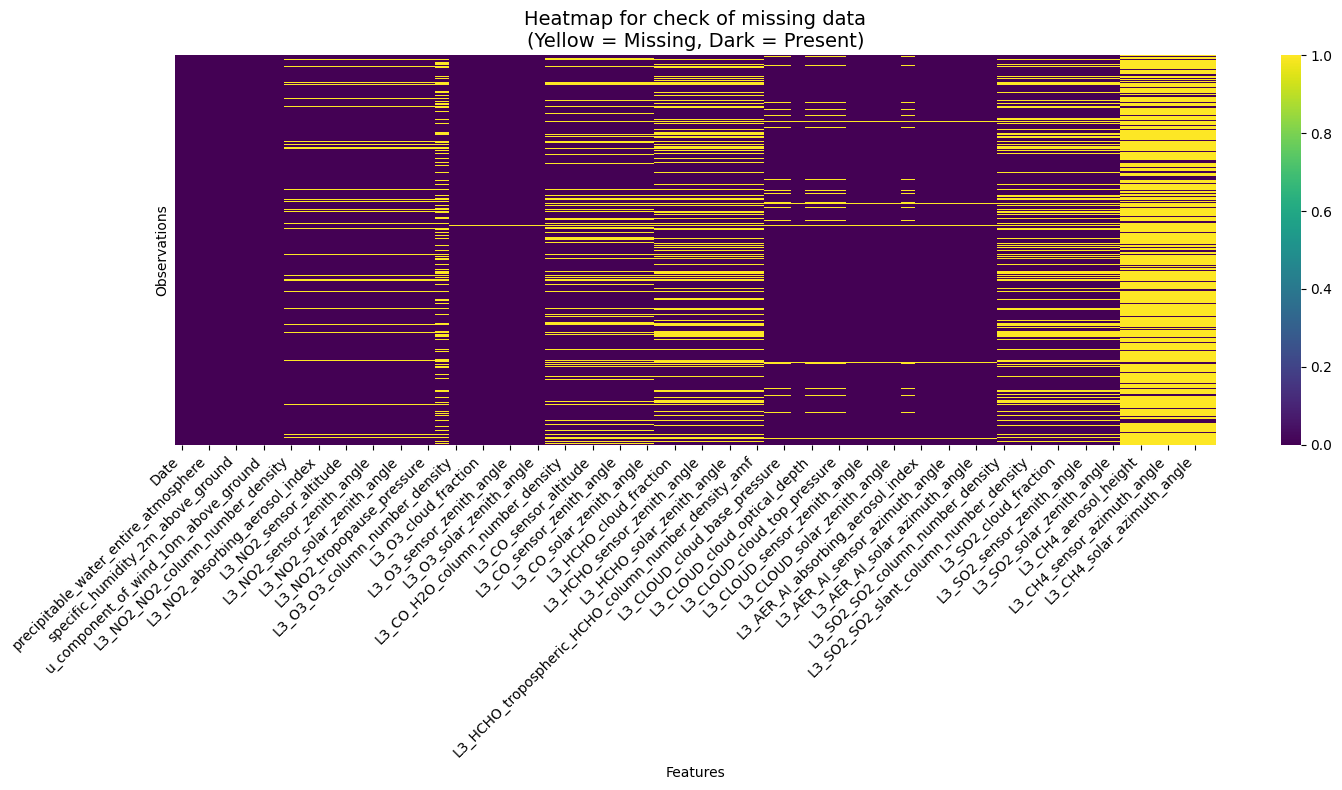

In [12]:
# Create missing data heatmap
plt.figure(figsize=(15, 8))

missing_data = X_train.isnull()
sns.heatmap(missing_data, yticklabels=False, cbar=True, cmap='viridis')
plt.title('Heatmap for check of missing data\n(Yellow = Missing, Dark = Present)', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Observations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We remove all columns with more than 50% of missing data:

In [13]:
cols = X_train.columns[X_train.isna().mean() > 0.5].tolist()

In [14]:
X_train = X_train.drop(columns = cols, axis = 1)
X_train = X_train.reset_index(drop=True)

In [15]:
X_val = X_val.drop(columns = cols, axis = 1)
X_val = X_val.reset_index(drop=True)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24445 entries, 0 to 24444
Data columns (total 69 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 24445 non-null  object 
 1   Place_ID                                             24445 non-null  object 
 2   precipitable_water_entire_atmosphere                 24445 non-null  float64
 3   relative_humidity_2m_above_ground                    24445 non-null  float64
 4   specific_humidity_2m_above_ground                    24445 non-null  float64
 5   temperature_2m_above_ground                          24445 non-null  float64
 6   u_component_of_wind_10m_above_ground                 24445 non-null  float64
 7   v_component_of_wind_10m_above_ground                 24445 non-null  float64
 8   L3_NO2_NO2_column_number_density                     22716 non-nul

In [17]:
X_train.describe()

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,...,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle
count,24445.000000,24445.000000,24445.000000,24445.000000,24445.000000,24445.000000,22716.000000,22716.000000,22716.000000,22716.000000,...,24283.000000,18690.000000,18690.000000,18690.000000,18635.000000,18690.000000,18690.000000,18690.000000,18690.000000,18690.000000
mean,15.336381,70.562947,0.006017,9.349889,0.414924,0.072386,0.000094,0.000163,-1.095917,0.278354,...,48.691044,0.000110,0.429034,0.000031,-1.945865,0.214337,-14.259942,35.603071,-123.650853,46.475245
std,10.716149,18.802477,0.003792,9.321077,2.706661,2.643526,0.000095,0.000109,0.612198,0.301640,...,14.307077,0.000928,0.251294,0.000172,0.710394,0.157834,76.045867,18.934930,71.750360,14.627388
min,0.420044,5.128572,0.000139,-34.647879,-15.559646,-15.023647,-0.000051,0.000000,-3.941742,0.000000,...,8.251382,-0.038756,0.000000,-0.004309,-4.825068,0.000000,-111.997123,0.000000,-179.880630,0.000000
25%,7.700000,58.600002,0.003410,3.150615,-1.092056,-1.431460,0.000056,0.000122,-1.516603,0.026806,...,38.277836,-0.000108,0.252271,-0.000043,-2.376181,0.077493,-97.721266,19.466335,-165.724037,36.613506
50%,12.281111,74.112502,0.004921,8.477583,0.224434,0.002605,0.000075,0.000150,-1.168067,0.150272,...,48.937301,0.000055,0.378349,0.000022,-1.964835,0.191302,-14.437552,37.982558,-156.506063,47.403793
75%,19.900000,85.500000,0.007587,16.282930,1.763406,1.537752,0.000111,0.000189,-0.746737,0.468959,...,59.281557,0.000280,0.551843,0.000097,-1.554452,0.345025,69.571461,52.220300,-118.295971,57.384903
max,72.599998,100.000000,0.021615,37.437921,17.955124,13.727925,0.002998,0.002431,4.824802,1.000000,...,87.491086,0.026994,2.137385,0.006988,3.736877,0.618176,80.544067,66.111289,179.776125,79.631711


## EDA


### Correlation between features

We here check the correlation between all features, as it appears the some have a high correlation with other features (corr >0.8). If that is the case, we drop one of the features

In [ ]:
import plotly.graph_objects as go


# Calculates de correlations matrix
corr_matrix = X_train.drop(['Place_ID','Date'], axis=1).corr()

# Create a mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_masked = corr_matrix.where(~mask)

# Creates heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr_masked.values,
    x=corr_masked.columns,
    y=corr_masked.columns,
    colorscale='RdBu_r',
    zmid=0,
    zmin=-1,
    zmax=1,
    text=np.round(corr_masked.values, 3),
    texttemplate='%{text}',
    textfont={"size": 8},
    colorbar=dict(title="Correlation"),
    hovertemplate='%{y} vs %{x}<br>Correlation: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title='Interactive Correlation Matrix of Features',
    title_font_size=16,
    width=1000,
    height=900,
    xaxis_title='Features',
    yaxis_title='Features',
    xaxis={'side': 'bottom'},
    yaxis={'autorange': 'reversed'}
)

fig.update_xaxes(tickangle=45)
fig.update_layout(
    width=1400,   
    height=1200   
)
fig.show(renderer='browser')

In [19]:
# Find features couples with corr > 0.8
threshold = 0.8
corr_matrix = X_train.drop(['Place_ID','Date'], axis=1).corr()

# Consider only upper triangle to avoid duplicates)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# find features that have corr > threshold
high_corr_indices = np.where((np.abs(corr_matrix) > threshold) & mask)

high_corr_pairs = [
    (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
    for i, j in zip(*high_corr_indices)
]

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df = high_corr_df.sort_values('Correlation', ascending=False, key=abs)
high_corr_df = high_corr_df.reset_index(drop=True) 

print(f"Found {len(high_corr_df)} pairs with |correlation| > {threshold}")
print(high_corr_df)

Found 96 pairs with |correlation| > 0.8
                               Feature 1   
0            L3_CLOUD_solar_zenith_angle  \
1             L3_HCHO_solar_zenith_angle   
2               L3_CO_solar_zenith_angle   
3               L3_CO_solar_zenith_angle   
4           L3_CLOUD_sensor_zenith_angle   
..                                   ...   
91  precipitable_water_entire_atmosphere   
92      L3_NO2_NO2_column_number_density   
93             L3_CO_solar_azimuth_angle   
94             L3_O3_solar_azimuth_angle   
95           L3_HCHO_solar_azimuth_angle   

                                 Feature 2  Correlation  
0             L3_AER_AI_solar_zenith_angle     0.999834  
1                L3_SO2_solar_zenith_angle     0.999687  
2               L3_HCHO_solar_zenith_angle     0.997475  
3                L3_SO2_solar_zenith_angle     0.997198  
4            L3_AER_AI_sensor_zenith_angle     0.996998  
..                                     ...          ...  
91         L3_CO_H2O_colu

In [20]:
# Track which features have been dropped
features_to_drop = set()

# Iterate through each pair in high_corr_df
for idx, row in high_corr_df.iterrows():
    feature1 = row['Feature 1']
    feature2 = row['Feature 2']
    
    # If feature1 is already dropped, skip this pair
    if feature1 in features_to_drop:
        continue
    
    # If feature2 is already dropped, skip this pair
    if feature2 in features_to_drop:
        continue
    
    # Drop feature2 (the second feature in the pair)
    features_to_drop.add(feature2)
    print(f"Dropping {feature2} (correlated with {feature1}: {row['Correlation']:.3f})")

print(f"\n\nTotal features to drop: {len(features_to_drop)}")
print(f"Features: {sorted(features_to_drop)}")

# Drop from X_train and X_val
X_train = X_train.drop(columns=features_to_drop, axis=1)
X_val = X_val.drop(columns=features_to_drop, axis=1)

print(f"\nNew shapes after dropping correlated features:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")


Dropping L3_AER_AI_solar_zenith_angle (correlated with L3_CLOUD_solar_zenith_angle: 1.000)
Dropping L3_SO2_solar_zenith_angle (correlated with L3_HCHO_solar_zenith_angle: 1.000)
Dropping L3_HCHO_solar_zenith_angle (correlated with L3_CO_solar_zenith_angle: 0.997)
Dropping L3_AER_AI_sensor_zenith_angle (correlated with L3_CLOUD_sensor_zenith_angle: 0.997)
Dropping L3_AER_AI_sensor_azimuth_angle (correlated with L3_CLOUD_sensor_azimuth_angle: 0.995)
Dropping L3_SO2_sensor_zenith_angle (correlated with L3_HCHO_sensor_zenith_angle: 0.994)
Dropping L3_CLOUD_cloud_top_height (correlated with L3_CLOUD_cloud_base_height: 0.993)
Dropping L3_CLOUD_sensor_azimuth_angle (correlated with L3_O3_sensor_azimuth_angle: 0.991)
Dropping L3_CLOUD_cloud_top_pressure (correlated with L3_CLOUD_cloud_base_pressure: 0.988)
Dropping L3_CLOUD_cloud_base_pressure (correlated with L3_CLOUD_cloud_base_height: -0.987)
Dropping L3_SO2_sensor_azimuth_angle (correlated with L3_HCHO_sensor_azimuth_angle: 0.986)
Dropping

In [21]:
# df_eda = pd.concat([X_train, y_train], axis=1)

In [22]:
# sns.pairplot(df_eda,corner=True);

### Correlations between features and target (PM2.5)


In [26]:
X_num = X_train.drop(['Place_ID','Date'],axis = 1)

In [27]:
correlations = pd.DataFrame({
    'feature': X_num.columns,
    'correlation': [X_num[col].corr(y_train.reset_index(drop=True)) for col in X_num.columns]
}).sort_values('correlation', ascending=False, key=abs)

print("Correlation of each feature with target:")
print(correlations)

Correlation of each feature with target:
                                              feature  correlation
17                     L3_CO_CO_column_number_density     0.377034
20           L3_HCHO_HCHO_slant_column_number_density     0.324386
26                          L3_AER_AI_sensor_altitude    -0.306901
5                    L3_NO2_NO2_column_number_density     0.303890
11                         L3_NO2_solar_azimuth_angle    -0.175380
19                          L3_CO_solar_azimuth_angle    -0.157843
29                     L3_SO2_absorbing_aerosol_index     0.157452
3                u_component_of_wind_10m_above_ground    -0.151319
7                               L3_NO2_cloud_fraction    -0.127864
23                       L3_CLOUD_cloud_optical_depth    -0.122158
18                                 L3_CO_cloud_height    -0.115431
21  L3_HCHO_tropospheric_HCHO_column_number_densit...    -0.113968
14                         L3_NO2_tropopause_pressure    -0.089509
15                   

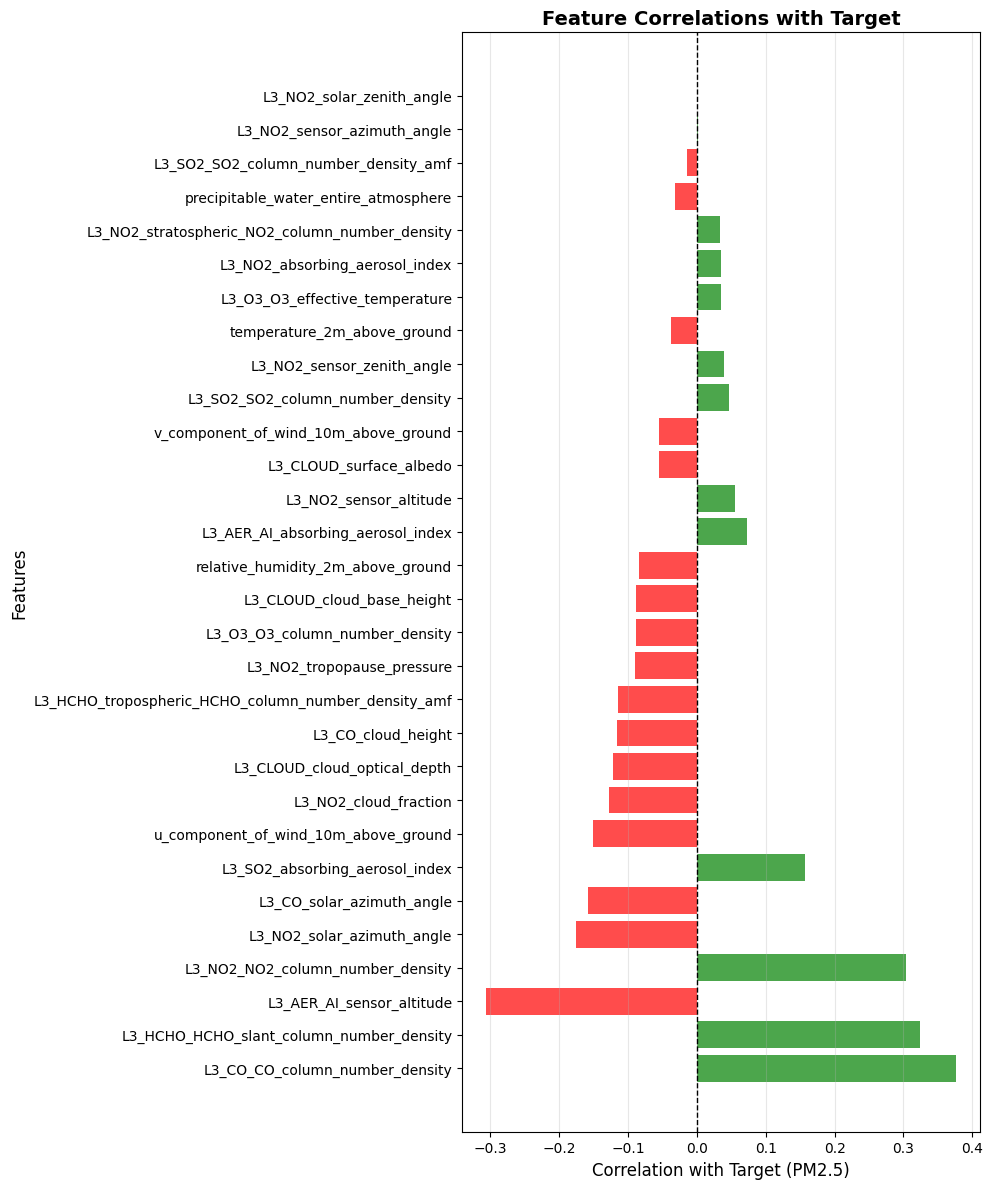

In [28]:
plt.figure(figsize=(10, 12))
colors = ['red' if x < 0 else 'green' for x in correlations['correlation']]
plt.barh(correlations['feature'], correlations['correlation'], color=colors, alpha=0.7)
plt.xlabel('Correlation with Target (PM2.5)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Correlations with Target', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Some other plots

## Feature engineering

### Preprocessing

In this part, we build the steps to input missing values and apply a standard scaling on the train set and the validation set.

For imputing, we consider the numerical columns:

In [20]:
num_cols = [col for col in X_train.columns if col not in id_cols and pd.api.types.is_numeric_dtype(X_train[col])]

In [21]:
X_train.columns

Index(['Date', 'Place_ID', 'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density', 'L3_NO2_absorbing_aerosol_index',
       'L3_NO2_cloud_fraction', 'L3_NO2_sensor_altitude',
       'L3_NO2_sensor_azimuth_angle', 'L3_NO2_sensor_zenith_angle',
       'L3_NO2_solar_azimuth_angle', 'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure', 'L3_O3_O3_column_number_density',
       'L3_O3_O3_effective_temperature', 'L3_CO_CO_column_number_density',
       'L3_CO_cloud_height', 'L3_CO_solar_azimuth_angle',
       'L3_HCHO_HCHO_slant_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density_amf',
       'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_optical_depth',
       'L3_CLOUD_surface_albedo', 'L3_AER_AI_absorbi

We impute the missing values using the mean per Place_ID

In [23]:
# Fill missing values per Place_ID using the group mean
X_imputed = X_train.copy()
# X_imputed[num_cols] = X_train.groupby('Place_ID')[num_cols].transform(lambda x: x.fillna(x.mean()))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class GroupByPlaceIDImputer(BaseEstimator, TransformerMixin):
    def __init__(self, place_id='Place_ID', strategy='mean'):
        self.place_id = place_id
        self.strategy = strategy
        
    def fit(self, X, y=None):        
        self.group_means_ = X.groupby(self.place_id)[num_cols].mean()
        self.overall_means_ = X[num_cols].mean()
        self.num_cols_ = num_cols
        return self
    
    def transform(self, X):
        X_filled = X.copy()
        
        # Map Place_ID to group means
        for col in self.num_cols_:
            # Create a mapping: Place_ID -> mean value for this column
            place_to_mean = self.group_means_[col].to_dict()
            
            # Fill NaN values
            mask = X_filled[col].isna()
            X_filled.loc[mask, col] = X_filled.loc[mask, self.place_id].map(place_to_mean)
            
            # Fill remaining NaN (for Place_IDs not in training) with overall mean
            X_filled[col] = X_filled[col].fillna(self.overall_means_[col])
        
        return X_filled

# Transforemer
imputer = GroupByPlaceIDImputer(place_id='Place_ID', strategy='mean')
X_imputed = imputer.fit_transform(X_train)  # Transform all the Dataseet

Inpute the missing values on the validation set:

In [ ]:
X_val_imputed = imputer.transform(X_val)

Missing values in X_val after imputation:
Empty DataFrame
Columns: [Amount, Percentage]
Index: []


Check the missing values again, as there could still be some extra missing values:

In [30]:
missing = pd.DataFrame(X_imputed.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/X_imputed.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage


We now define a preprocessing pipeline to impute all the missing NaNs and to scale all the data with a standard scaler

In [ ]:
pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy='mean')),  # its optional to keep it as we already filled the missing values but its a safety layer for the future unseen data
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', pipeline, num_cols),
], remainder='passthrough')

Column transformer changes the order of the columns, have to take this into account

In [43]:
column_order = num_cols + ['Date','Place_ID']
X_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=column_order)

for col in num_cols:
    X_preprocessed[col] = pd.to_numeric(X_preprocessed[col], errors='coerce')


In [44]:
X_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24445 entries, 0 to 24444
Data columns (total 32 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   precipitable_water_entire_atmosphere                 24445 non-null  float64
 1   relative_humidity_2m_above_ground                    24445 non-null  float64
 2   temperature_2m_above_ground                          24445 non-null  float64
 3   u_component_of_wind_10m_above_ground                 24445 non-null  float64
 4   v_component_of_wind_10m_above_ground                 24445 non-null  float64
 5   L3_NO2_NO2_column_number_density                     24445 non-null  float64
 6   L3_NO2_absorbing_aerosol_index                       24445 non-null  float64
 7   L3_NO2_cloud_fraction                                24445 non-null  float64
 8   L3_NO2_sensor_altitude                               24445 non-nul

Apply the preprocessing pipeline on the validation set:

In [53]:
X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val_imputed), 
    columns=column_order
)
for col in num_cols:
    X_val_preprocessed[col] = pd.to_numeric(X_val_preprocessed[col], errors='coerce')
print("X_val_preprocessed shape:", X_val_preprocessed.shape)
X_val_preprocessed.info()

X_val_preprocessed shape: (6112, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6112 entries, 0 to 6111
Data columns (total 32 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   precipitable_water_entire_atmosphere                 6112 non-null   float64       
 1   relative_humidity_2m_above_ground                    6112 non-null   float64       
 2   temperature_2m_above_ground                          6112 non-null   float64       
 3   u_component_of_wind_10m_above_ground                 6112 non-null   float64       
 4   v_component_of_wind_10m_above_ground                 6112 non-null   float64       
 5   L3_NO2_NO2_column_number_density                     6112 non-null   float64       
 6   L3_NO2_absorbing_aerosol_index                       6112 non-null   float64       
 7   L3_NO2_cloud_fraction                             

All good now! Let's move forward

## Trainining the model

In [46]:
# Convert Date to datetime
X_preprocessed['Date'] = pd.to_datetime(X_preprocessed['Date'])
X_val['Date'] = pd.to_datetime(X_val['Date'])

In [47]:
X_preprocessed = X_preprocessed.drop(['Date','Place_ID'], axis=1)

In [48]:
#training the model
reg = LinearRegression().fit(X_preprocessed, y_train)

In [49]:
y_train_pred = reg.predict(X_preprocessed)
mse = mean_squared_error(y_train, y_train_pred)
print(mse)

1453.3999667781102


In [50]:
rmse = np.sqrt(mse)
print(rmse)

38.12348314068522


In [51]:
r2 = r2_score(y_train, y_train_pred)
print(r2)

0.3378146411778489
